In [388]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import mne
import warnings
import datetime


from data_extraction import  Extract_data_from_subject
from data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
from keras.constraints import max_norm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold



np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 


#%load_ext tensorboard
#%tensorboard --logdir logs

# Notes on Data Extraction:

### Parameters
> - Sampling Rate (fs) = 256
> - data type: eeg, exg or baseline
> - T-start: start of window (t=0: focus, t=0.5: arrow, t=1: cue (thinking), t=3.5: rest t=4.5: end)
> - T-end: close of window
> - N_S: subject number (1 through 10)
> - N_B: Session (batch) number

### Extract_subject_from_BDF(root_dir,N_S,N_B):

> Loads raw data for subject and session. Takes the directory pointing to folder containing all recordings
> and preprocessed files, subject number and session/batch number, and returns (raw data, subject number)

### Extract_data_from_subject(root_dir,N_S,datatype):

> Loads all blocks for one subject and stacks results. Takes the directory, calls the file for specified data 
> under the specified subject, and stacks all samples into one object. Also calls the labels. Returns (X,Y): 
> object with stacked trials/samples, and object with correlated labels.

### Extract_block_data_from_subject(root_dir,N_S,datatype,N_B):

> Does the same as above Extract_data_from_subject, but for a specified N_B (batch or session number).
> returns (data samples, labels)

### Extract_report(root_dir,N_B,N_S):

> Pulls report with information regarding the given subject and session. Includes subject age, gender,
> length of recording, count of correct and incorrect answer to control questions, position of contaminated
> trials, mean power for EXG channels 7 & 8, and mean and STD for EXG 7 & 8 baseline recordings.

### Extract_TFR(TRF_dir, Cond, Class, TFR_method , TRF_type):

> Returns Time-Frequency Representation of specified condition and class. 
>
> *Note: location of TRF data unclear, not likely to use in scope of project.*

### Extract_data_multisubject(root_dir, N_S_list, datatype='EEG'):

> Creates a stacked object of all sessions for all listed subjects and returns the stacked trials/samples
> along with a stack of the corresponding labels.

### load_events(root_dir,N_S,N_B):

> Loads the events file to gather the label(s) for dataset using root directory, subject, and batch number.

### Select_time_window(X,t_start=1, t_end=2.5, fs=256):

> Cuts samples to desired time window.

### Transform_for_classificator (X, Y, Classes, Conditions):

> Pulls from the extracted dataset the trials and labels that correspond to the conditions and classes that
> will be used for training and/or testing.


In [389]:
root_dir = '/kaggle/input/inner-speech-recognition/inner-speech-recognition'

In [390]:
N_S = 10
datatype = 'eeg'
Tstart = 1.5
Tend = 3.5
fs = 256

X,Y = Extract_data_from_subject(root_dir,N_S,datatype)

In [391]:
Subj = Select_time_window(X = X, t_start = Tstart, t_end = Tend, fs = fs)

In [392]:
X_1, Y_1 = Transform_for_classificator(X = Subj, Y = Y, Classes = [['ALL']], Conditions = [['Vis']])

In [393]:
X_2, Y_2 = Transform_for_classificator(X = Subj, Y = Y, Classes = [['ALL']], Conditions = [['Inner']])

In [395]:
X = np.concatenate((X_1, X_2), axis=0)
Y = np.concatenate((Y_1, Y_2), axis=0)

In [399]:
input_shape = (X.shape[1],X.shape[2],1)
print(input_shape)



(128, 512, 1)


In [401]:
# one-hot encoding
Y[:,(0,1)].shape
# print(Labels_2_inner[:,(0,1)])
labels = Y[:,1]
y = pd.get_dummies(labels)


In [408]:
X.shape
reshaped_data = X[1]
#reshaped_data.shape
X.shape

(480, 128, 512)

In [413]:
#plt.plot(X[1,:,:]);

In [414]:
X_resize = X * (10**4)
#plt.plot(X_resize[1,:,:]);

In [417]:
# one-hot encoding
Y_1[:,(0,1)].shape
# print(Labels_2_inner[:,(0,1)])
labels_1 = Y_1[:,1]
y_1 = pd.get_dummies(labels_1)

In [418]:
# one-hot encoding
Y_2[:,(0,1)].shape
# print(Labels_2_inner[:,(0,1)])
labels_2 = Y_2[:,1]
y_2 = pd.get_dummies(labels_2)

In [419]:
X_resize_1 = X_1 * (10**4)

In [420]:
X_resize_2 = X_2 * (10**4)

In [421]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X_1, X_2, Y_1, Y_2 are your datasets with four labels

# Perform train-test split for X_1 and Y_1
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_resize_1, y_1, test_size=0.2, random_state=0)

# Perform train-test split for X_2 and Y_2
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_resize_2, y_2, test_size=0.2, random_state=0)



In [422]:
# Combine the results for X and Y for the test set
X_test = np.concatenate((X_test_1, X_test_2), axis=0)
y_test = np.concatenate((y_test_1, y_test_2), axis=0)

X_train_ = np.concatenate((X_train_1, X_train_2), axis=0)
y_train_ = np.concatenate((y_train_1, y_train_2), axis=0)

In [423]:
# Perform train-validation split for the combined training set
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.1,random_state=0)

In [424]:
# split data into train and test set
#X_train_, X_test, y_train_, y_test = train_test_split(X_resize, y, test_size=0.2)


In [425]:
# Assuming X_train and y_train are your training data
#X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.1, random_state=0)


## 2. Implement CNN

In [426]:
'''Adam_ = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.001)


def create_cnn(input_shape):
    # create model - Sequential class, linear stack of layers can be added
    model = models.Sequential()
    # first layer 
    model.add(layers.Conv2D(32, kernel_size = (1,5), padding = 'valid', activation='relu', input_shape = input_shape, strides = (1,2)))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    # second layer
    model.add(layers.Conv2D(32, kernel_size = (1,5), padding = 'valid', activation='relu'))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten output before last convolutional layer
    model.add(layers.Flatten())
    # Add a fully connected layer 
    model.add(layers.Dense(3000, activation='relu'))
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5)) # 0.2 is the default
    # Output layer 
    model.add(layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile( 
        optimizer = 'adam', 
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        )    
    
    return model

model = create_cnn(input_shape)

model.summary() 
'''

"Adam_ = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.001)\n\n\ndef create_cnn(input_shape):\n    # create model - Sequential class, linear stack of layers can be added\n    model = models.Sequential()\n    # first layer \n    model.add(layers.Conv2D(32, kernel_size = (1,5), padding = 'valid', activation='relu', input_shape = input_shape, strides = (1,2)))\n    # adds max pooling layer\n    model.add(layers.MaxPooling2D(pool_size=(1, 2)))\n    # second layer\n    model.add(layers.Conv2D(32, kernel_size = (1,5), padding = 'valid', activation='relu'))\n    # adds max pooling layer\n    model.add(layers.MaxPooling2D(pool_size=(2, 2)))\n    # flatten output before last convolutional layer\n    model.add(layers.Flatten())\n    # Add a fully connected layer \n    model.add(layers.Dense(3000, activation='relu'))\n    # Add Dropout for regularization\n    model.add(layers.Dropout(0.5)) # 0.2 is the default\n    # Output layer \n    model.add(layers.Dense(4, activation='softmax

In [427]:
Adam_ = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)
# L1_ = tf.keras.regularizers.L1(l1=0.0005)

def create_cnn(input_shape):
    # create model - Sequential class, linear stack of layers can be added
    model = models.Sequential()
    # first layer
    model.add(layers.Conv2D(32, kernel_size = (1,31), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,1)))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    # second layer
#     model.add(layers.Conv2D(8, kernel_size = (128,1), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,1)))    
    # depthwise layer
    model.add(layers.DepthwiseConv2D((128,1), padding = 'valid', activation='relu'))
    # adds max pooling layer
#     model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten output before last convolutional layer
    model.add(layers.Flatten())
    # Add a fully connected layer 
    model.add(layers.Dense(200, activation='relu')) 
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5)) # 0.2 is the default
    # Add a second fully connected layer 
    model.add(layers.Dense(50, activation='relu')) 
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5))
    # Output layer 
    model.add(layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile( 
        optimizer = Adam_, # default
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        )    
    
    return model

model = create_cnn(input_shape)

model.summary()       

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 482, 32)      1024      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 128, 241, 32)      0         
 g2D)                                                            
                                                                 
 depthwise_conv2d_27 (Depth  (None, 1, 241, 32)        4128      
 wiseConv2D)                                                     
                                                                 
 flatten_27 (Flatten)        (None, 7712)              0         
                                                                 
 dense_45 (Dense)            (None, 200)               1542600   
                                                                 
 dropout_18 (Dropout)        (None, 200)             

## EEGNET Version

In [428]:
def EEGNet(input_shape): 
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, kernel_size = (1,64), padding = 'same', input_shape = input_shape))
    model.add(layers.BatchNormalization())
    
    model.add(layers.DepthwiseConv2D((128,1), depth_multiplier = 2, depthwise_constraint = max_norm(1.)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size=(1, 4)))    
    model.add(layers.SpatialDropout2D(0.25))
    
    model.add(layers.SeparableConv2D(16, kernel_size = (1,16), padding = 'same'))
    model.add(layers.BatchNormalization()) 
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size=(1, 8)))    
    model.add(layers.SpatialDropout2D(0.25))
              
    model.add(layers.Flatten())
    model.add(layers.Dense(4, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer = 'adam', # default
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        ) 
              
    return model

model = EEGNet(input_shape)

model.summary() 


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 128, 512, 8)       520       
                                                                 
 batch_normalization_54 (Ba  (None, 128, 512, 8)       32        
 tchNormalization)                                               
                                                                 
 depthwise_conv2d_28 (Depth  (None, 1, 512, 16)        2064      
 wiseConv2D)                                                     
                                                                 
 batch_normalization_55 (Ba  (None, 1, 512, 16)        64        
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 1, 512, 16)        0         
                                                     

In [429]:
# Early Stopping    
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Reduce Learning Rate
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    mode='auto',
    min_lr=0.00001,
)

# Train model 
def fit_evaluate(X_train, X_val,  y_train, y_val, epochs = 50, batch_size = 16): 
    model = EEGNet(input_shape)
    results = model.fit(X_train, y_train, epochs, batch_size, verbose= 1, callbacks=[EarlyStopping, ReduceLR], validation_split = 0.1)
    print("Val Score: ", model.evaluate(X_val, y_val))
    
    return results


In [43]:
# first model
model_history1 = fit_evaluate(X_train, X_val, y_train, y_val, epochs = 50, batch_size = 16)

Epoch 1/16
6/6 [==============================] - 15s 2s/step - loss: 1.5098 - accuracy: 0.3089 - val_loss: 1.3878 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 2/16
6/6 [==============================] - 12s 2s/step - loss: 1.4607 - accuracy: 0.2587 - val_loss: 1.3887 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 3/16
6/6 [==============================] - 12s 2s/step - loss: 1.4525 - accuracy: 0.3127 - val_loss: 1.3892 - val_accuracy: 0.1034 - lr: 0.0010
Epoch 4/16
1/1 [==============================] - 0s 271ms/step - loss: 1.3865 - accuracy: 0.1562
Val Score:  [1.386549472808838, 0.15625]


In [86]:
# second model
model_history2 = fit_evaluate(X_train, X_val, y_train, y_val, epochs = 50, batch_size = 16)

Epoch 1/16
7/7 [==============================] - 17s 2s/step - loss: 1.5977 - accuracy: 0.2452 - val_loss: 1.3849 - val_accuracy: 0.3143 - lr: 0.0010
Epoch 2/16
7/7 [==============================] - 15s 2s/step - loss: 1.4468 - accuracy: 0.2677 - val_loss: 1.3848 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 3/16
7/7 [==============================] - 15s 2s/step - loss: 1.3864 - accuracy: 0.3097 - val_loss: 1.3843 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 4/16
7/7 [==============================] - 14s 2s/step - loss: 1.3436 - accuracy: 0.3129 - val_loss: 1.3843 - val_accuracy: 0.3143 - lr: 0.0010
Epoch 5/16
7/7 [==============================] - 15s 2s/step - loss: 1.3623 - accuracy: 0.3613 - val_loss: 1.3857 - val_accuracy: 0.3429 - lr: 0.0010
Epoch 6/16
7/7 [==============================] - 14s 2s/step - loss: 1.2717 - accuracy: 0.3968 - val_loss: 1.3867 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 7/16
2/2 [==============================] - 0s 62ms/step - loss: 1.3868 - accuracy: 0.23

In [129]:
model_history3 = fit_evaluate(X_train, X_val, y_train, y_val, 50, 16)

Epoch 1/16
6/6 [==============================] - 14s 2s/step - loss: 1.5160 - accuracy: 0.2780 - val_loss: 1.3867 - val_accuracy: 0.2414 - lr: 0.0010
Epoch 2/16
6/6 [==============================] - 13s 2s/step - loss: 1.4674 - accuracy: 0.2703 - val_loss: 1.3864 - val_accuracy: 0.2414 - lr: 0.0010
Epoch 3/16
6/6 [==============================] - 12s 2s/step - loss: 1.4607 - accuracy: 0.2625 - val_loss: 1.3864 - val_accuracy: 0.1724 - lr: 0.0010
Epoch 4/16
6/6 [==============================] - 12s 2s/step - loss: 1.3984 - accuracy: 0.3205 - val_loss: 1.3862 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 5/16
6/6 [==============================] - 12s 2s/step - loss: 1.3648 - accuracy: 0.3282 - val_loss: 1.3862 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 6/16
6/6 [==============================] - 12s 2s/step - loss: 1.3347 - accuracy: 0.3822 - val_loss: 1.3865 - val_accuracy: 0.2414 - lr: 0.0010
Epoch 7/16
1/1 [==============================] - 0s 269ms/step - loss: 1.3929 - accuracy: 0.1

In [172]:
model_history4 = fit_evaluate(X_train, X_val, y_train, y_val, 50, 16)

Epoch 1/16
7/7 [==============================] - 16s 2s/step - loss: 1.4855 - accuracy: 0.2710 - val_loss: 1.3862 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 2/16
7/7 [==============================] - 15s 2s/step - loss: 1.4544 - accuracy: 0.2806 - val_loss: 1.3858 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 3/16
7/7 [==============================] - 15s 2s/step - loss: 1.4112 - accuracy: 0.3161 - val_loss: 1.3870 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 4/16
7/7 [==============================] - 15s 2s/step - loss: 1.3594 - accuracy: 0.3742 - val_loss: 1.3878 - val_accuracy: 0.1429 - lr: 0.0010
Epoch 5/16
2/2 [==============================] - 0s 61ms/step - loss: 1.3870 - accuracy: 0.2564
Val Score:  [1.3869560956954956, 0.25641027092933655]


In [215]:
model_history5 = fit_evaluate(X_train, X_val, y_train, y_val, 50, 16)

Epoch 1/16
7/7 [==============================] - 17s 2s/step - loss: 1.5805 - accuracy: 0.2065 - val_loss: 1.3844 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/16
7/7 [==============================] - 15s 2s/step - loss: 1.4954 - accuracy: 0.2677 - val_loss: 1.3838 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/16
7/7 [==============================] - 14s 2s/step - loss: 1.3866 - accuracy: 0.3226 - val_loss: 1.3845 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/16
7/7 [==============================] - 15s 2s/step - loss: 1.3736 - accuracy: 0.3452 - val_loss: 1.3858 - val_accuracy: 0.2286 - lr: 0.0010
Epoch 5/16
2/2 [==============================] - 0s 62ms/step - loss: 1.3874 - accuracy: 0.1795
Val Score:  [1.3874231576919556, 0.1794871836900711]


In [258]:
model_history6 = fit_evaluate(X_train, X_val, y_train, y_val, 50, 16)

Epoch 1/16
6/6 [==============================] - 15s 2s/step - loss: 1.6667 - accuracy: 0.2410 - val_loss: 1.3864 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 2/16
6/6 [==============================] - 13s 2s/step - loss: 1.4278 - accuracy: 0.3201 - val_loss: 1.3864 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 3/16
6/6 [==============================] - 14s 2s/step - loss: 1.4852 - accuracy: 0.2806 - val_loss: 1.3863 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 4/16
6/6 [==============================] - 13s 2s/step - loss: 1.4058 - accuracy: 0.3381 - val_loss: 1.3862 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 5/16
6/6 [==============================] - 14s 2s/step - loss: 1.3638 - accuracy: 0.3489 - val_loss: 1.3862 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 6/16
6/6 [==============================] - 13s 2s/step - loss: 1.3454 - accuracy: 0.3417 - val_loss: 1.3863 - val_accuracy: 0.2581 - lr: 0.0010
Epoch 7/16
2/2 [==============================] - 0s 32ms/step - loss: 1.3847 - accuracy: 0.31

In [301]:
model_history7 = fit_evaluate(X_train, X_val, y_train, y_val, 50, 16)

Epoch 1/16
7/7 [==============================] - 17s 2s/step - loss: 1.5629 - accuracy: 0.2129 - val_loss: 1.3866 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 2/16
7/7 [==============================] - 15s 2s/step - loss: 1.4409 - accuracy: 0.2935 - val_loss: 1.3864 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 3/16
7/7 [==============================] - 15s 2s/step - loss: 1.3777 - accuracy: 0.3032 - val_loss: 1.3860 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 4/16
7/7 [==============================] - 14s 2s/step - loss: 1.3963 - accuracy: 0.3097 - val_loss: 1.3860 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 5/16
7/7 [==============================] - 15s 2s/step - loss: 1.3434 - accuracy: 0.3484 - val_loss: 1.3862 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 6/16
7/7 [==============================] - 14s 2s/step - loss: 1.2886 - accuracy: 0.4000 - val_loss: 1.3863 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 7/16
2/2 [==============================] - 0s 65ms/step - loss: 1.3861 - accuracy: 0.28

In [344]:
model_history8 = fit_evaluate(X_train, X_val, y_train, y_val, 50, 16)

Epoch 1/16
6/6 [==============================] - 15s 2s/step - loss: 1.5427 - accuracy: 0.2664 - val_loss: 1.3871 - val_accuracy: 0.1034 - lr: 0.0010
Epoch 2/16
6/6 [==============================] - 13s 2s/step - loss: 1.4845 - accuracy: 0.2703 - val_loss: 1.3879 - val_accuracy: 0.1034 - lr: 0.0010
Epoch 3/16
6/6 [==============================] - 12s 2s/step - loss: 1.4022 - accuracy: 0.2780 - val_loss: 1.3872 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 4/16
6/6 [==============================] - 13s 2s/step - loss: 1.3741 - accuracy: 0.3591 - val_loss: 1.3866 - val_accuracy: 0.2759 - lr: 0.0010
Epoch 5/16
6/6 [==============================] - 13s 2s/step - loss: 1.3270 - accuracy: 0.3398 - val_loss: 1.3868 - val_accuracy: 0.2759 - lr: 0.0010
Epoch 6/16
6/6 [==============================] - 12s 2s/step - loss: 1.3639 - accuracy: 0.2896 - val_loss: 1.3869 - val_accuracy: 0.1034 - lr: 0.0010
Epoch 7/16
1/1 [==============================] - 0s 265ms/step - loss: 1.3866 - accuracy: 0.1

In [387]:
model_history9 = fit_evaluate(X_train, X_val, y_train, y_val, 50, 16)

Epoch 1/16
7/7 [==============================] - 17s 2s/step - loss: 1.5963 - accuracy: 0.2742 - val_loss: 1.3858 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 2/16
7/7 [==============================] - 16s 2s/step - loss: 1.5245 - accuracy: 0.2516 - val_loss: 1.3850 - val_accuracy: 0.3714 - lr: 0.0010
Epoch 3/16
7/7 [==============================] - 15s 2s/step - loss: 1.4573 - accuracy: 0.3032 - val_loss: 1.3844 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 4/16
7/7 [==============================] - 23s 3s/step - loss: 1.4426 - accuracy: 0.3065 - val_loss: 1.3844 - val_accuracy: 0.3429 - lr: 0.0010
Epoch 5/16
7/7 [==============================] - 27s 4s/step - loss: 1.4470 - accuracy: 0.2968 - val_loss: 1.3839 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 6/16
7/7 [==============================] - 15s 2s/step - loss: 1.3958 - accuracy: 0.3323 - val_loss: 1.3835 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 7/16
7/7 [==============================] - 15s 2s/step - loss: 1.3811 - accuracy: 0.280

In [434]:
model_history10 = fit_evaluate(X_train, X_val, y_train, y_val, 50, 50)

Epoch 1/50
7/7 [==============================] - 16s 2s/step - loss: 1.5794 - accuracy: 0.2548 - val_loss: 1.3864 - val_accuracy: 0.3429 - lr: 0.0010
Epoch 2/50
7/7 [==============================] - 19s 3s/step - loss: 1.4377 - accuracy: 0.3258 - val_loss: 1.3861 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 3/50
7/7 [==============================] - 26s 4s/step - loss: 1.4585 - accuracy: 0.3129 - val_loss: 1.3853 - val_accuracy: 0.4571 - lr: 0.0010
Epoch 4/50
7/7 [==============================] - 15s 2s/step - loss: 1.4021 - accuracy: 0.3258 - val_loss: 1.3858 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 5/50
7/7 [==============================] - 15s 2s/step - loss: 1.3948 - accuracy: 0.3097 - val_loss: 1.3862 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 6/50
2/2 [==============================] - 0s 62ms/step - loss: 1.3847 - accuracy: 0.3333
Val Score:  [1.3846760988235474, 0.3333333432674408]


## Plotting Results

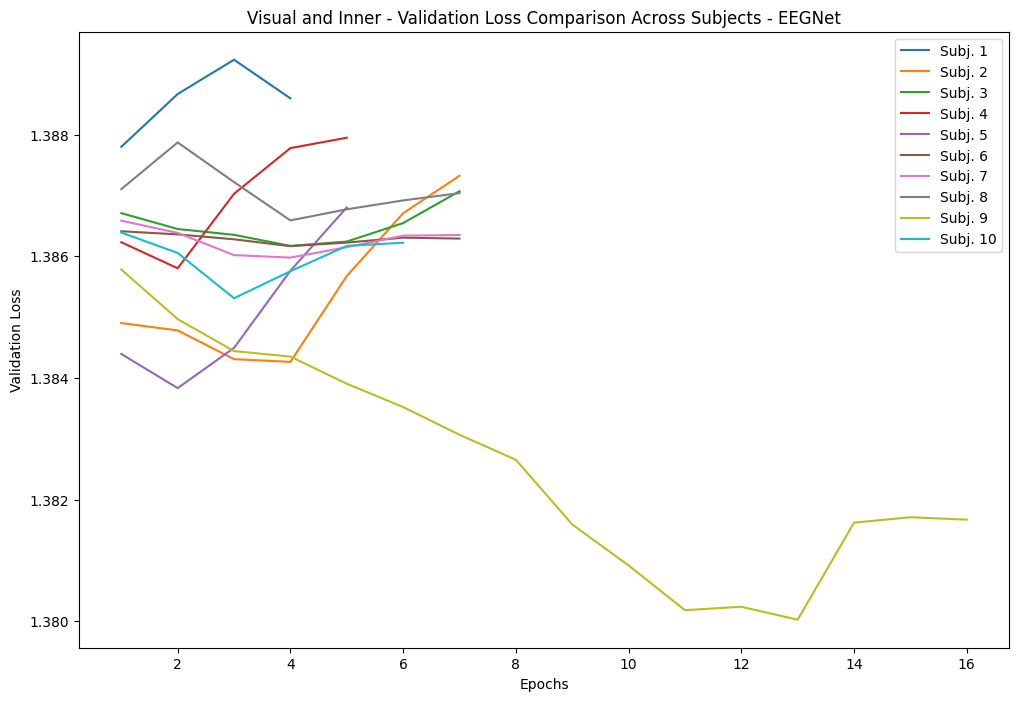

In [435]:
import seaborn as sns

plt.figure(figsize=(12, 8))

sns.lineplot(x=range(1, len(model_history1.history['val_loss']) + 1), y=model_history1.history['val_loss'], label='Subj. 1')
sns.lineplot(x=range(1, len(model_history2.history['val_loss']) + 1), y=model_history2.history['val_loss'], label='Subj. 2')
sns.lineplot(x=range(1, len(model_history3.history['val_loss']) + 1), y=model_history3.history['val_loss'], label='Subj. 3')
sns.lineplot(x=range(1, len(model_history4.history['val_loss']) + 1), y=model_history4.history['val_loss'], label='Subj. 4')
sns.lineplot(x=range(1, len(model_history5.history['val_loss']) + 1), y=model_history5.history['val_loss'], label='Subj. 5')
sns.lineplot(x=range(1, len(model_history6.history['val_loss']) + 1), y=model_history6.history['val_loss'], label='Subj. 6')
sns.lineplot(x=range(1, len(model_history7.history['val_loss']) + 1), y=model_history7.history['val_loss'], label='Subj. 7')
sns.lineplot(x=range(1, len(model_history8.history['val_loss']) + 1), y=model_history8.history['val_loss'], label='Subj. 8')
sns.lineplot(x=range(1, len(model_history9.history['val_loss']) + 1), y=model_history9.history['val_loss'], label='Subj. 9')
sns.lineplot(x=range(1, len(model_history10.history['val_loss']) + 1), y=model_history10.history['val_loss'], label='Subj. 10')


plt.title('Visual and Inner - Validation Loss Comparison Across Subjects - EEGNet')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


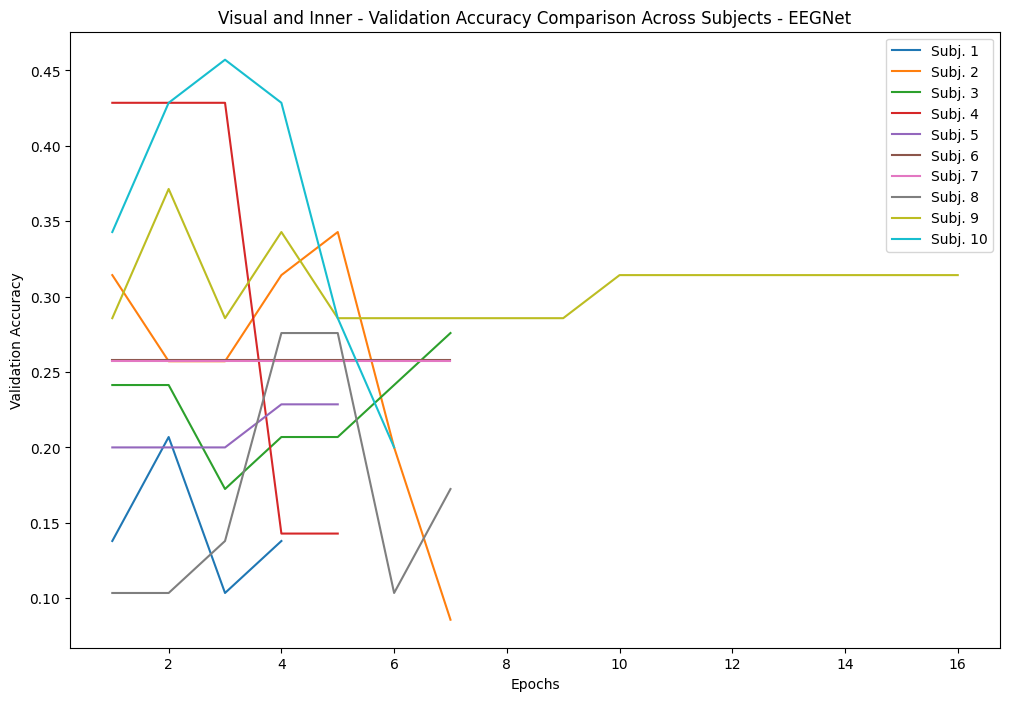

In [436]:
plt.figure(figsize=(12, 8))

sns.lineplot(x=range(1, len(model_history1.history['val_accuracy']) + 1), y=model_history1.history['val_accuracy'], label='Subj. 1')
sns.lineplot(x=range(1, len(model_history2.history['val_accuracy']) + 1), y=model_history2.history['val_accuracy'], label='Subj. 2')
sns.lineplot(x=range(1, len(model_history3.history['val_accuracy']) + 1), y=model_history3.history['val_accuracy'], label='Subj. 3')
sns.lineplot(x=range(1, len(model_history4.history['val_accuracy']) + 1), y=model_history4.history['val_accuracy'], label='Subj. 4')
sns.lineplot(x=range(1, len(model_history5.history['val_accuracy']) + 1), y=model_history5.history['val_accuracy'], label='Subj. 5')
sns.lineplot(x=range(1, len(model_history6.history['val_accuracy']) + 1), y=model_history6.history['val_accuracy'], label='Subj. 6')
sns.lineplot(x=range(1, len(model_history7.history['val_accuracy']) + 1), y=model_history7.history['val_accuracy'], label='Subj. 7')
sns.lineplot(x=range(1, len(model_history8.history['val_accuracy']) + 1), y=model_history8.history['val_accuracy'], label='Subj. 8')
sns.lineplot(x=range(1, len(model_history9.history['val_accuracy']) + 1), y=model_history9.history['val_accuracy'], label='Subj. 9')
sns.lineplot(x=range(1, len(model_history10.history['val_accuracy']) + 1), y=model_history10.history['val_accuracy'], label='Subj. 10')

plt.title('Visual and Inner - Validation Accuracy Comparison Across Subjects - EEGNet')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()


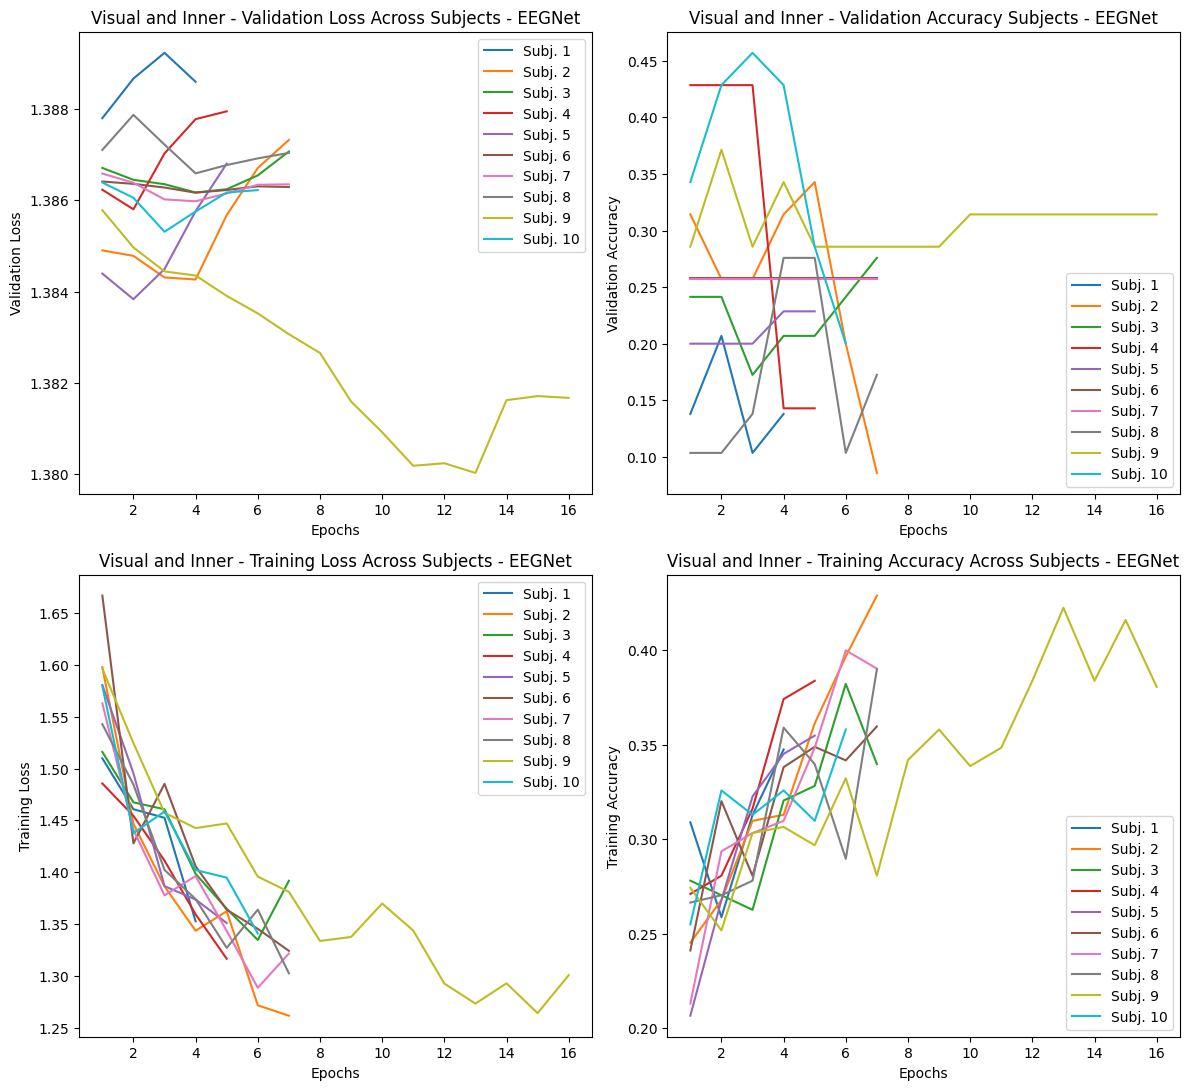

In [437]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 16))

# Plot Validation Loss
plt.subplot(3, 2, 1)
for i in range(1, 11):
    sns.lineplot(x=range(1, len(locals()[f'model_history{i}'].history['val_loss']) + 1),
                 y=locals()[f'model_history{i}'].history['val_loss'], label=f'Subj. {i}')

plt.title('Visual and Inner - Validation Loss Across Subjects - EEGNet')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(3, 2, 2)
for i in range(1, 11):
    sns.lineplot(x=range(1, len(locals()[f'model_history{i}'].history['val_accuracy']) + 1),
                 y=locals()[f'model_history{i}'].history['val_accuracy'], label=f'Subj. {i}')

plt.title('Visual and Inner - Validation Accuracy Subjects - EEGNet')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(3, 2, 3)
for i in range(1, 11):
    sns.lineplot(x=range(1, len(locals()[f'model_history{i}'].history['loss']) + 1),
                 y=locals()[f'model_history{i}'].history['loss'], label=f'Subj. {i}')

plt.title('Visual and Inner - Training Loss Across Subjects - EEGNet')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(3, 2, 4)
for i in range(1, 11):
    sns.lineplot(x=range(1, len(locals()[f'model_history{i}'].history['accuracy']) + 1),
                 y=locals()[f'model_history{i}'].history['accuracy'], label=f'Subj. {i}')

plt.title('Visual and Inner - Training Accuracy Across Subjects - EEGNet')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()

plt.tight_layout()
# Save the figure
plt.savefig('comparison_plot_EEGNet.png')
plt.show()


In [ ]:
n_folds = 5
epochs = 50
batch_size = 16

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
train_fold = []
val_fold = []
model_history = []

for train_ind, val_ind in skf.split(X_train, np.argmax(y_train, axis=1)):
    train_fold.append(train_ind)
    val_fold.append(val_ind)

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    
    X_train_i = X_train[train_fold[i]]
    y_train_i = y_train.values[train_fold[i]]  # Convert to NumPy array
    
    X_val_i = X_train[val_fold[i]]
    y_val_i = y_train.values[val_fold[i]]  # Convert to NumPy array
    
    model_history.append(fit_evaluate(X_train_i, X_val_i, y_train_i, y_val_i, epochs, batch_size))
    
    print("=======" * 12, end="\n\n\n")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, history in enumerate(histories):
    plt.plot(history.history['val_loss'], label=f'Model {i+1}')

plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Find the fold with the best validation accuracy
best_fold_idx = np.argmax([np.max(model_history[i].history['val_accuracy']) for i in range(n_folds)])

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2)

# Plot the best fold
ax[0].plot(model_history[best_fold_idx].history['accuracy'], label=f'Fold {best_fold_idx + 1} Train')
ax[0].plot(model_history[best_fold_idx].history['val_accuracy'], label=f'Fold {best_fold_idx + 1} Validation')

ax[1].plot(model_history[best_fold_idx].history['loss'], label=f'Fold {best_fold_idx + 1} Train')
ax[1].plot(model_history[best_fold_idx].history['val_loss'], label=f'Fold {best_fold_idx + 1} Validation')

# Set common titles and labels
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')

ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Visualize history
# Loss
for i in range(n_folds):
    plt.plot(model_history[i].history['val_loss'], label=f'Training Fold {i + 1}')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.show()


# Validation Accuracy
for i in range(n_folds):
    plt.plot(model_history[i].history['val_accuracy'], label=f'Training Fold {i + 1}')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.show()



In [ ]:
# Accuracy
for i in range(n_folds):
    plt.plot(model_history[i].history['accuracy'], label=f'Training Fold {i + 1}')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
#%tensorboard --logdir logs/fit

In [1]:
pred_y = model.predict(
    X_test,
    verbose =1
)

NameError: name 'model' is not defined

In [ ]:
#print(pred_y)

In [ ]:
score = model.evaluate(
    X_test,
    y_test,
    batch_size = 24,
    verbose =2
)

## Further Data Exploration - Topoplots, Channel Localization

In [403]:
Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
info = mne.create_info(ch_names=X.shape[1], sfreq=256, ch_types='eeg')


In [405]:
mapping = {str(i): ch_name for i, ch_name in enumerate(montage.ch_names)}
info.rename_channels(mapping)

<Info | 7 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 128 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 256.0 Hz
>

In [406]:
mapping = {ch_name: 'eeg' for ch_name in montage.ch_names}
info.set_channel_types(mapping)

<Info | 7 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 128 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 256.0 Hz
>

In [409]:
mean_data = np.mean(X, axis=0)

In [410]:
# Create a RawArray object using reshaped data
raw = mne.io.RawArray(X[1], info)

# Plot the sensors with the applied montage
#fig = raw.plot_sensors(show_names=True)


In [411]:
#raw.plot(n_channels=50, color = 'steelblue',show_scrollbars= False, show_scalebars= False, time_format="float")


In [412]:
import mne
import numpy as np

# Assuming 'raw' is your Raw object

# Number of time segments
num_segments = 4
segment_size = raw.n_times // num_segments

# Plot topoplots for each segment
for i in range(num_segments):
    start_idx = i * segment_size
    end_idx = (i + 1) * segment_size if i < num_segments - 1 else raw.n_times
    mean_data = np.mean(raw.get_data()[:, start_idx:end_idx], axis=1)
    
    info = raw.info

    #mne.viz.plot_topomap(mean_data, info, show=True, contours= True, res=300, sensors='k.', size=5, vlim =(-0.00001,0.00001))
